In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, confusion_matrix
import seaborn as sns


In [2]:
# Load data
df = pd.read_csv('data/995,000_row_cleaned.csv')

# Remove rows with ivalid values
label_map = {"fake": 1, "satire":1, "conspiracy": 1, "bias": 1, "rumor": 1, "junksci": 1, "hate": 1,  "clickbait": 1,   "political": 1,
             "reliable": 0} # unreliable isn't kept because it's not conclusive data 
df = df[df["type"].isin(label_map.keys())]  # Keep only rows with valid labels
print(df["type"].value_counts())
df["type"] = df["type"].map(label_map)
print(df["type"].value_counts())

# Split data 
texts = df["content"]
y = df["type"]

# Create a instances of the TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,  # make sure the number of features is 10000
    ngram_range=(1, 2),  # Use uni- and bi-grams
)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, y, 
    test_size=0.2,
    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,
    shuffle=False)

# Fit and transform the vectorizer on the training data
X_train = vectorizer.fit_transform(X_train)  
X_val = vectorizer.transform(X_val)       
X_test = vectorizer.transform(X_test)  

# Save the fitted vectorizer
dump(vectorizer, 'models/tfidf_vectorizer.joblib')

/var/folders/z1/hf1tn63x7tl1qjxy1md9xy4w0000gn/T/ipykernel_17825/4153333985.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/995,000_row_cleaned.csv')


type
reliable      218564
political     194518
bias          133232
fake          104883
conspiracy     97314
rumor          56445
clickbait      27412
junksci        14040
satire         13160
hate            8779
Name: count, dtype: int64
type
1    649783
0    218564
Name: count, dtype: int64


['models/tfidf_vectorizer.joblib']

In [3]:
# Standard model
# Define the model
input_layer = Input(shape=(X_train.shape[1],), sparse=True)
x1 = layers.Dense(1000, activation="relu")(input_layer) # 1st hidden layer with 1000 neurons
x1 = layers.Dropout(0.4)(x1)                            # Dropout layer to prevent overfitting 
x2 = layers.Dense(500, activation="relu")(x1)           # 2nd hidden layer with 500 neurons
x2 = layers.Dropout(0.2)(x2)                            # Dropout layer to prevent overfitting
x3 = layers.Dense(100, activation="relu")(x2)           # 3rd hidden layer with 100 neurons
x4 = layers.Dense(25, activation="relu")(x3)            # 4th hidden layer with 25 neurons
output = layers.Dense(1, activation="sigmoid")(x4)      # Output layer with 1 neuron and sigmoid to force binary

# Create the model
NN = tf.keras.models.Model(inputs=input_layer, outputs=output)

#Initialize the NN
NN.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score()],
    weighted_metrics=["f1_score"],  # Weight the F1 metric higher
)

# Define the callbacks for early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_f1_score',     # Use F1 for early stopping
        mode='max',                 # We want to "maximize" the F1 score  
        patience=4,                 # If theres no improvements after 4 epochs, stop
        restore_best_weights=True
    )
]

# Define the weights for the classes
weight_for_0 = len(y_train) / (2.0 * (y_train == 0).sum())
weight_for_1 = len(y_train) / (2.0 * (y_train == 1).sum())
class_weights = {0: weight_for_0, 1: weight_for_1}

#Train the NN
history = NN.fit(
    X_train,y_train,                    # Trainin data as input and expected output
    validation_data = (X_val,y_val),    # Data for validation
    epochs = 10,                        # Number of iterations over the entire dataset
    batch_size = 1024,                  # Number of samples per gradient update
    callbacks=callbacks,                # Use the callback
    class_weight=class_weights          # Use the class weights
)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 99s 145ms/step - f1_score: 0.8599 - loss: 0.2107 - precision: 0.9686 - recall: 0.9145 - weighted_f1_score: 0.6691 - val_f1_score: 0.8719 - val_loss: 0.1306 - val_precision: 0.9804 - val_recall: 0.9517 - val_weighted_f1_score: 0.8719
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 99s 146ms/step - f1_score: 0.8908 - loss: 0.0910 - precision: 0.9869 - recall: 0.9705 - weighted_f1_score: 0.7289 - val_f1_score: 0.8863 - val_loss: 0.1085 - val_precision: 0.9805 - val_recall: 0.9624 - val_weighted_f1_score: 0.8863
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 99s 146ms/step - f1_score: 0.9057 - loss: 0.0380 - precision: 0.9956 - recall: 0.9878 - weighted_f1_score: 0.7601 - val_f1_score: 0.8965 - val_loss: 0.1128 - val_precision: 0.9785 - val_recall: 0.9696 - val_weighted_f1_score: 0.8965
Epoch 4/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 101s 149ms/step - f1_score: 0.9157 - loss: 0.0201 - precision: 0.9976 - recall: 0.9934 - weighted_f1_score: 0.7817 - val_f1_score: 0.9073 - v

In [4]:
# Save the model
output_path = "models/nn_classifier.keras"
NN.save(output_path) 

In [ ]:
# Load the model
input_path = "models/nn_classifier.keras"
NN = tf.keras.models.load_model(input_path)

In [5]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))

    plt.title('Confusion Matrix')
    sns.set_theme(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    

679/679 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step
NeuralNetwork MSE:  0.03455979749560356
NeuralNetwork accuracy:  0.9654402026832498
NeuralNetwork F1 score:  0.9764381668721097


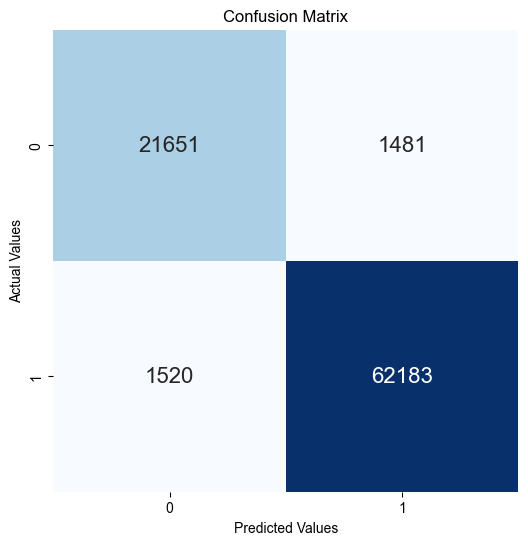

In [6]:
y_pred = NN.predict(X_test, batch_size=128)
y_pred = np.round(y_pred).flatten()

print("NeuralNetwork MSE: ", mean_squared_error(y_test, y_pred))
print("NeuralNetwork accuracy: ", accuracy_score(y_test, y_pred))
print("NeuralNetwork F1 score: ", f1_score(y_test, y_pred))
conf_matrix(y_test, y_pred)